# PSB injection bump in Xsuite - correct beta beating

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_02_with_chicane_time_functions.json')
line.build_tracker()

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Insert a marker at location where we want to minimize beta beating

In [4]:
line.discard_tracker() # We need to discard the tracker to edit the line
line.insert_element(element=xt.Marker(), name='mker_match', at_s=79.874)
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Store twiss with chicane off

In [5]:
line.vars['on_chicane_k0'] = 0
line.vars['on_chicane_k2'] = 0

tw0 = line.twiss()

line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Compute correction using `match`

In [6]:
t_correct = np.linspace(0, 5.5e-3, 30) # Times at which corrections are computed

kbrqf_corr_list = []
kbrqd_corr_list = []
kbrqd3corr_list = []
kbrqd14corr_list = []

for ii, tt in enumerate(t_correct):
    print(f'Correct tune and beta beat at t = {tt * 1e3:.2f} ms', end='\r', flush=True)
    
    line.vars['t_turn_s'] = tt # Set test time

    xd.general._print.suppress = True # to avoid too much output
    line.match(
        targets=[
            xt.Target('qx', value=tw0.qx, tol=1e-5, scale=1),
            xt.Target('qy', value=tw0.qy, tol=1e-5, scale=1),
            xt.Target('bety', at='mker_match',
                      value=tw0['bety', 'mker_match'], tol=1e-4, scale=100),
            xt.Target('alfy', at='mker_match',
                       value=tw0['alfy', 'mker_match'], tol=1e-4, scale=100)
        ],
        vary=[
            xt.Vary('kbrqfcorr', step=1e-4),
            xt.Vary('kbrqdcorr', step=1e-4),
            xt.Vary('kbrqd3corr', step=1e-4),
            xt.Vary('kbrqd14corr', step=1e-4),
        ],
    )
    xd.general._print.suppress = False

    # Store found values
    kbrqf_corr_list.append(line.vars['kbrqfcorr']._value)
    kbrqd_corr_list.append(line.vars['kbrqdcorr']._value)
    kbrqd3corr_list.append(line.vars['kbrqd3corr']._value)
    kbrqd14corr_list.append(line.vars['kbrqd14corr']._value)

In [7]:
# Ispect
kbrqf_corr_list

[-0.000567579827505881,
 -0.00046279169256173566,
 -0.00035013831697402933,
 -0.0002333465452702425,
 -0.00011657436934074044,
 -7.210011983091371e-05,
 -4.868832111434691e-05,
 -2.721636863730785e-05,
 -7.7166903753239e-06,
 9.77321998653984e-06,
 2.5232739638790165e-05,
 3.862617792759999e-05,
 4.9923683235166566e-05,
 5.909594737466051e-05,
 6.611710721253843e-05,
 7.095968733594036e-05,
 7.359807992718279e-05,
 7.400823950472431e-05,
 7.216592843881327e-05,
 6.804912999437387e-05,
 6.163891742262684e-05,
 5.2909721016956546e-05,
 4.184725042554934e-05,
 2.365687971704366e-05,
 1.1221374666308988e-05,
 4.39197813652616e-06,
 9.083433927691302e-07,
 6.480876375811727e-10,
 6.480876375811727e-10,
 6.480876375811727e-10]

### Build functions with the computed corrections

In [8]:
line.functions['fun_kqf_corr'] = xd.FunctionPieceWiseLinear(x=t_correct, y=kbrqf_corr_list)
line.functions['fun_kqd_corr'] = xd.FunctionPieceWiseLinear(x=t_correct, y=kbrqd_corr_list)
line.functions['fun_qd3_corr'] = xd.FunctionPieceWiseLinear(x=t_correct, y=kbrqd3corr_list)
line.functions['fun_qd14_corr'] = xd.FunctionPieceWiseLinear(x=t_correct, y=kbrqd14corr_list)

### Use functions to control quadrupole strengths

In [9]:
line.vars['on_chicane_tune_corr'] = 1
line.vars['kbrqfcorr'] = (line.vars['on_chicane_tune_corr']
                            * line.functions.fun_kqf_corr(line.vars['t_turn_s']))
line.vars['kbrqdcorr'] = (line.vars['on_chicane_tune_corr']
                            * line.functions.fun_kqd_corr(line.vars['t_turn_s']))

line.vars['on_chicane_beta_corr'] = 1
line.vars['kbrqd3corr'] = (line.vars['on_chicane_beta_corr']
                         * line.functions.fun_qd3_corr(line.vars['t_turn_s']))
line.vars['kbrqd14corr'] = (line.vars['on_chicane_beta_corr']
                        * line.functions.fun_qd14_corr(line.vars['t_turn_s']))

### Check corrections

In [10]:
t_test = np.linspace(0, 6e-3, 100)

qy = []
qy_uncorrected = []
bety_at_mker = []
bety_at_mker_uncorrected = []

for ii, tt in enumerate(t_test):
    print(f'Twiss at t = {tt*1e3:.2f} ms   ', end='\r', flush=True)
    
    line.vars['t_turn_s'] = tt # Set test times

    line.vars['on_chicane_beta_corr'] = 1
    line.vars['on_chicane_tune_corr'] = 1
    
    tw = line.twiss()
    qy.append(tw.qy)
    bety_at_mker.append(tw['bety', 'mker_match'])

    line.vars['on_chicane_beta_corr'] = 0
    line.vars['on_chicane_tune_corr'] = 0
    
    tw_uncorr = line.twiss()
    
    bety_at_mker_uncorrected.append(tw_uncorr['bety', 'mker_match'])
    qy_uncorrected.append(tw_uncorr.qy)

<IPython.core.display.Javascript object>


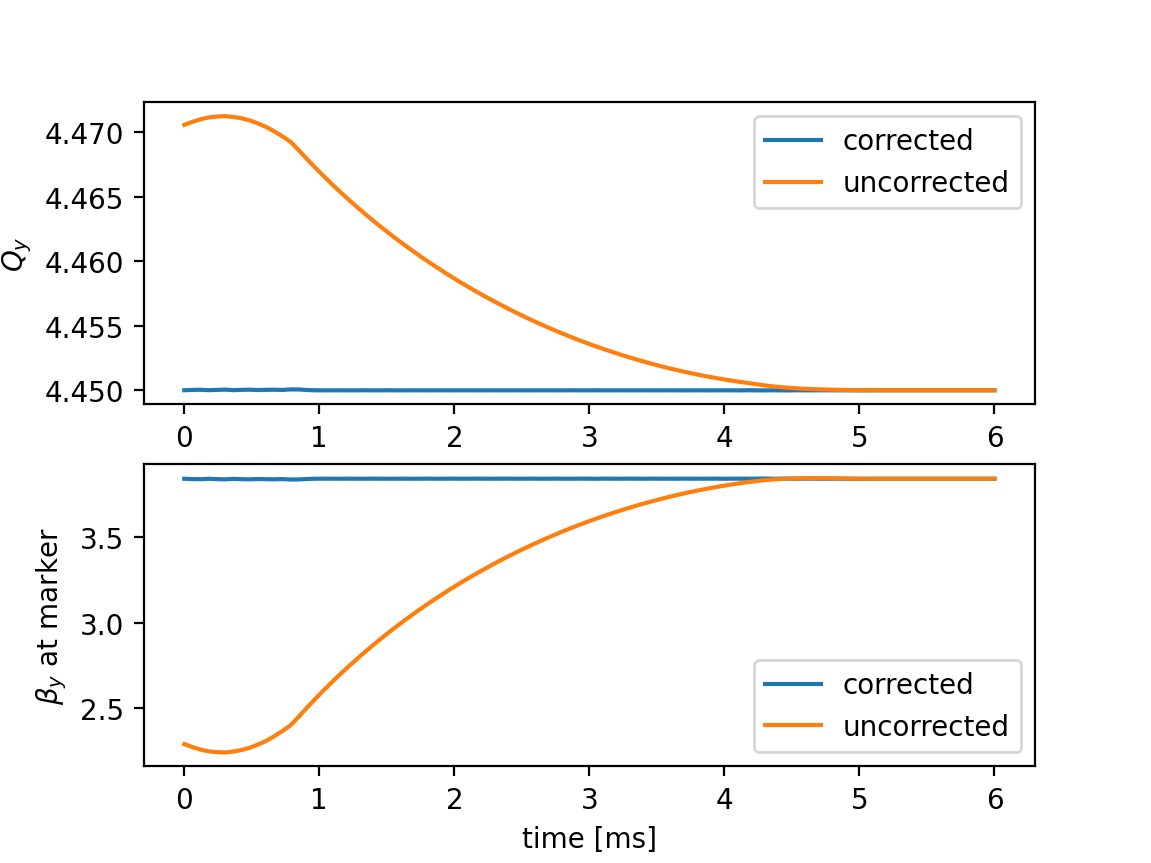

Text(0.5, 0, 'time [ms]')

In [11]:
plt.figure(2, figsize=(6.4*0.9, 4.8*0.9))
sp1 = plt.subplot(2,1,1)
plt.plot(t_test*1e3, qy, label='corrected')
plt.plot(t_test*1e3, qy_uncorrected, label='uncorrected')
plt.ylabel('$Q_y$')
plt.legend()
sp2 = plt.subplot(2,1,2, sharex=sp1)
plt.plot(t_test*1e3, bety_at_mker , label='corrected')
plt.plot(t_test*1e3, bety_at_mker_uncorrected, label='uncorrected')
plt.ylabel(r'$\beta_y$ at marker')
plt.legend()
plt.xlabel('time [ms]')


<IPython.core.display.Javascript object>


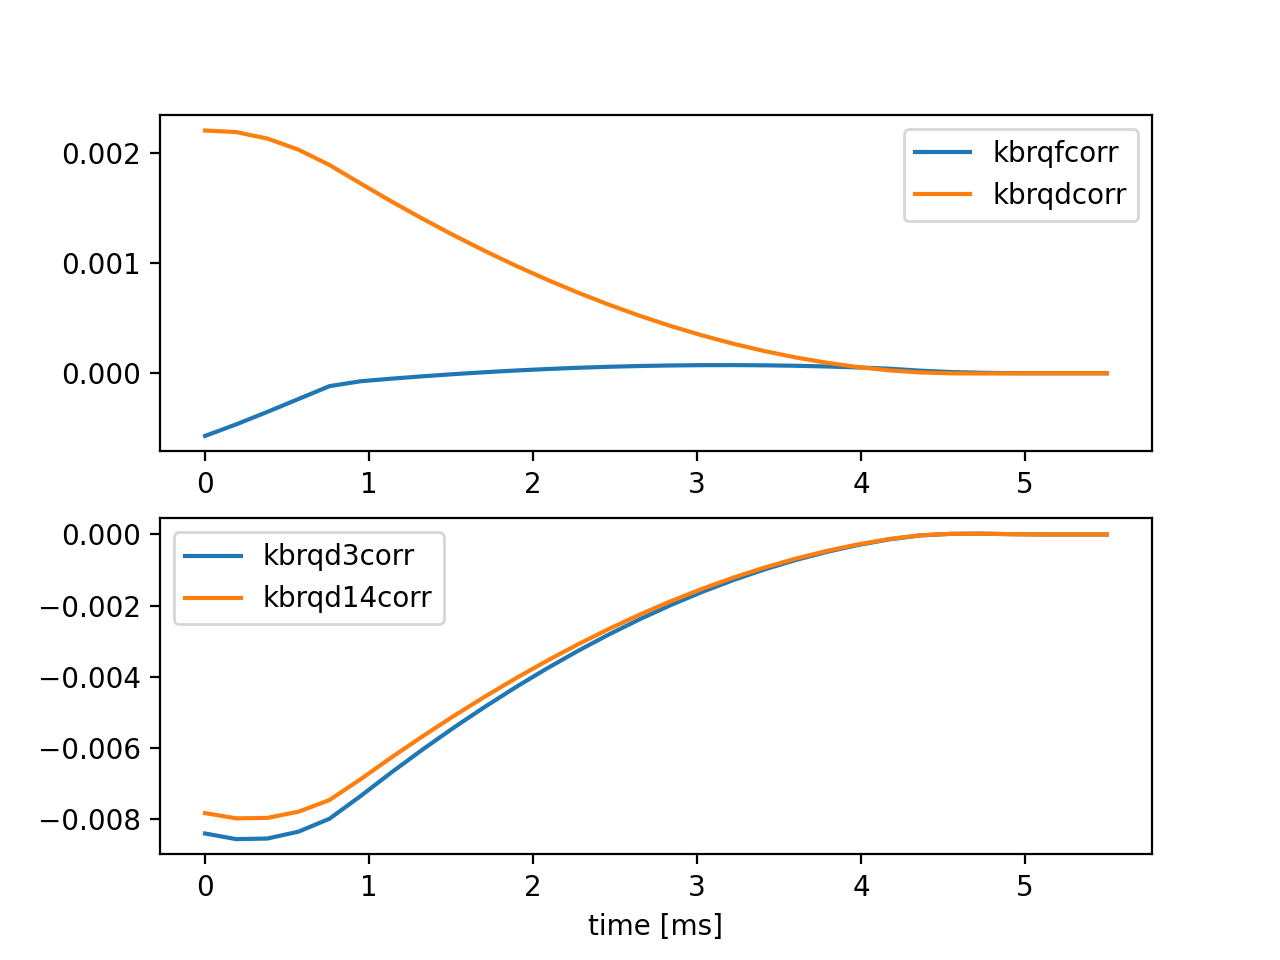

Text(0.5, 0, 'time [ms]')

In [12]:
plt.figure()
sp1 = plt.subplot(2,1,1)
plt.plot(t_correct*1e3, kbrqf_corr_list, label='kbrqfcorr')
plt.plot(t_correct*1e3, kbrqd_corr_list, label='kbrqdcorr')
plt.legend()
plt.subplot(2,1,2, sharex=sp1)
plt.plot(t_correct*1e3, kbrqd3corr_list, label='kbrqd3corr')
plt.plot(t_correct*1e3, kbrqd14corr_list, label='kbrqd14corr')
plt.legend()
plt.xlabel('time [ms]')

### Save

In [13]:
line.to_json('psb_03_with_chicane_corrected.json')